# Simulating Diffusion in Volumes

The simulation script described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/diffusion.ipynb).

This chapter introduces how to model and simulate diffusion systems.
First we will look at how to describe the diffusive motion of molecules
by using object of class [steps.model.Diff](API_model.rst#steps.model.Diff), then how to import
a tetrahedral mesh by using the [steps.utilities.meshio](API_utilities_meshio.rst#steps.utilities.meshio) methods
and finally how to create a [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) object to be used for
the simulation itself. The `Tetexact` solver builds on the `Wmdirect` solver
(we have used up until now) extended for diffusive fluxes between tetrahedral
elements in a mesh. Each individual tetrahedron behaves like a well-mixed
compartment where reactions can take place. Diffusive flux between
tetrahedral elements is represented by a series of first-order reactions
with rate constants derived from the local geometry and the diffusion
constant parameter. Thus, this solver object can be used to simulate
full reaction-diffusion systems in complex geometries, but in this introduction
we will start with a simple diffusion system.

We wish to simulate diffusion of one molecular species from a point source
in an infinite volume, a problem chosen for simplicity and with a known analytical
solution we can compare to our STEPS simulation results. As the volume in STEPS
must of course be finite we will create a large spherical mesh, inject our
molecules into the central tetrahedron (as there is no concept of a point
source in STEPS) and compare our results to the analytical solution up to a
time when there are zero or an insignificant number of boundary events.

## Analytical solution

To compare our mean results in STEPS to an analytical solution we must solve
the diffusion equation for one spatial dimension, the radial distance from the
point source. The problem is simplified to one dimension because the symmetry
of the problem dictates that, in the deterministic limit, the concentration at any given radial distance r
from the point source will be equal at all points in space forming a
two-dimensional “shell” at that *r*.

If all molecules exist at a single point at time 0, within an infinite boundary,
the analytical solution is (see e.g. Crank, J. (1975) The Mathematics of Diffusion.
Oxford: Clarendon Press):

\begin{equation}
    C(r,t)=\frac{N}{8(\pi Dt)^{3/2}}\exp\left(\frac{-r^{2}}{4Dt}\right)
\end{equation}
 
where *C* is the concentration (if length units are meters the units of C are number of molecules/ $m^{\text{3}}$)
at radial distance *r*  from source at time *t*, *N* is the total number of injected
molecules and *D* is the diffusion constant (in units $m^{\text{2}}/s$) .

## Modelling solution

### Organisation of code

To set up our model and run our simulation we will create a Python script,
organising the script according to a certain template chosen for a good
organisation of our workflow. However, for clarity, in these examples we
will show the code as if it was typed at the Python prompt. As in previous
chapters we will go through the code step by step and look at the statements in
detail as we go.

The first thing to do is to write statements to import all our steps packages
with all the methods available to describe our model and run our simulation.
We will also import other packages we require at this point in the script,
such as `math`, `numpy`, `pylab` and `random`. We will make use of the `random` package
to help with selecting tetrahedrons from our mesh to sample (which we look at
in detail later) and `math` contains many useful basic mathematical functions we'll use
for finding the analytical solution:


In [1]:
import math
import numpy
import pylab
import random
import time

import steps.model as smodel
import steps.solver as solvmod
import steps.geom as stetmesh
import steps.rng as srng

Now we set some parameters for our simulation. By keeping these variables grouped
together at the beginning of a Python script we would make it easy to locate and
change these simulation parameters if we wished to. We will use capital letters
for the variables here so it is clear later in the script that they are constants:


In [2]:
# The number of iterations to run
NITER = 10

# The data collection time increment (s)
DT = 0.001

# The simulation endtime (s)
INT = 0.101

# The number of molecules to be injected into the centre
NINJECT = 10000

# The number of tetrahedral elements to sample data from.
SAMPLE = 2000

# The diffusion constant for our diffusing species (m^2/s)
DCST = 20.0e-12

At what stage these constants will be used will become clear as we work
through the code.

We want to sample data from individual tetrahedrons so we can analyse spatial
data, so we now create two objects to store the indices and radial distance from
center of the mesh tetrahedrons we will sample.  **Note**: *Tetrahedrons are identified by an integer index (as are nodes and
   triangles). We look at this in more detail in the geometry section.*

We have decided in this case that
we don't want to save data for every single tetrahedron, but rather randomly
select 2000 tetrahedrons by setting the SAMPLE variable to 2000, perhaps due to memory constraints.
We will look at how we select which tetrahedrons to sample in [Geometry specification](diffusion.ipynb#Geometry-specification)
, but for now we just create NumPy arrays initialized to zeros.
The reason for creating these arrays at this point in the script will become
clear later:


In [3]:
# Array to hold tetrahedron indices (integers)
tetidxs = numpy.zeros(SAMPLE, dtype='int')

# Array to hold tetrahedron radial distances (floats)
tetrads = numpy.zeros(SAMPLE)

### Model specification

So we now move on to our model description. This time we will organise the code
into a function, which will return the [steps.model.Model](API_model.rst#steps.model.Model) object we create. It is
entirely up to you if you wish to organise your model description in this way,
but it can be useful for larger models. **Note**: *In this way, for example, multiple model descriptions can be defined
   in a separate module with each description clearly separated inside functions.
   You can then import whichever model description objects you chose into the
   simulation scripts. We will not explore this topic in detail here, but it is a
   good idea to keep in mind that this organisation is an option.*

This is our first function
definition, so lets mention a little about the syntax for defining functions in
Python. Firstly, we use the `def` statement to create a function object and assign
it a name. Then we must provide all our function code with the same indentation.
As soon as our indentation returns to the indentation for the `def` statement, we
exit the function definition. We wish to return our [steps.model.Model](API_model.rst#steps.model.Model) object,
so we will provide a `return` statement at the end of the function. First we create
our function and name it `gen_model`. In this simple example the function will not
require any arguments, so its signature will be `gen_model()`.

We start, as always, by creating our [steps.model.Model](API_model.rst#steps.model.Model) container object `mdl`. 

In [4]:
mdl = smodel.Model()    

Then we create our molecular species (only one in this simple model we will call `A`) and our volume system `vsys`, much as in previous chapters.

In [5]:
A = smodel.Spec('A', mdl)    
vsys = smodel.Volsys('cytosolv', mdl)

After that we can create our diffusion rule. In STEPS this means creating a [steps.model.Diff](API_model.rst#steps.model.Diff)
object and assigning it to a volume system ([steps.model.Volsys](API_model.rst#steps.model.Volsys)). As well as the usual identifier string and a reference to the parent volume system, a required parameter for the object construction is a reference to the molecular species object to which this diffusion rule applies. An optional parameter to the object constructor is the diffusion constant, which is given in s.i. units (i.e. $m^{2}/s$ so for example a diffusion constant of $100 \mu m^{2}/s = 100*10^{-12} m^{\text{2}}/s$).

The default value for the diffusion constant can be changed with object method
[steps.model.Diff.setDcst](API_model.rst) and can even be changed from the default value in any compartment during simulation, much like the reaction constants we looked at in previous chapters. However, in
this model we will not alter the diffusion constant later in the script, so this
is the value that will be used during our simulation. Recall we defined the diffusion constant at the beginning or our script, the reason for which is that this value is available in a variable when we come to finding the analytical solution.

In [6]:
diff_A = smodel.Diff('diff_A', vsys, A)
diff_A.setDcst(DCST)

So our complete function is:

In [7]:
def gen_model():    
    mdl = smodel.Model()    
    A = smodel.Spec('A', mdl)    
    vsys = smodel.Volsys('cytosolv', mdl)
    diff_A = smodel.Diff('diff_A', vsys, A)
    diff_A.setDcst(DCST)
    return mdl 

### Geometry specification

We now move on to describing our geometry. This is the section that stands out as
very different to our previous well-mixed simulations. The methods we
provide for describing mesh-based geometry in STEPS give tools for importing meshes
from some powerful mesh-generation packages, and methods for initialising and
controlling your simulation conditions which are beyond the ground covered in this
chapter. It is likely that you will only start to get the feel of how to use these
methods to achieve your required description in more complex models with hands-on
experience. This chapter begins to introduce some useful methods for mesh
manipulation and it is hoped that this will give the user enough experience with
the workflow to be able to go on to more advanced object manipulation that may be
required for more complex models. A full list of tetrahedral mesh methods is
available in [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) and [steps.utilities.meshio](API_utilities_meshio.rst#steps.utilities.meshio).

We chose to structure all our geometry code into a function, much like our model description. 

We start by loading our mesh object. STEPS provides all mesh loading and saving tools in
module [steps.utilities.meshio](API_utilities_meshio.rst#steps.utilities.meshio). This module currently provides support for
[TetGen](http://wias-berlin.de/software/index.jsp?id=TetGen), [CUBIT](http://cubit.sandia.gov/) and
[NETGEN](http://www.hpfem.jku.at/netgen/) mesh generators, along with any
others supporting the Abaqus output format. The details of creating a mesh
from these 3rd party packages and importing into STEPS are beyond the scope of
this chapter, however we provide a full list of meshio methods in [steps.utilities.meshio](API_utilities_meshio.rst#steps.utilities.meshio).
One of the functions provided in meshio is [steps.utilities.meshio.saveMesh](API_utilities_meshio.rst#steps.utilities.meshio.saveMesh), which allows the user to
save the imported mesh in STEPS format. This is important because the information
passed on from the mesh generators is often only very basic information about the
mesh and STEPS must find a vast amount of information to pass on to the [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact)
reaction-diffusion solver object internally. This can be time-consuming for large
meshes, however this process only needs to be performed once. With [steps.utilities.meshio.saveMesh](API_utilities_meshio.rst#steps.utilities.meshio.saveMesh) the
mesh is saved with basic information in an XML file, with an accompanying ASCII file
containing all the extra information STEPS computed when importing the mesh. After
these files have been created, the mesh can then be imported with the [steps.utilities.meshio.loadMesh](API_utilities_meshio.rst#steps.utilities.meshio.loadMesh)
method, which will only take a few seconds or minutes to load even very large
meshes. Therefore, it is highly recommended that all meshes are saved in this way
by using the [steps.utilities.meshio.saveMesh](API_utilities_meshio.rst#steps.utilities.meshio.saveMesh) function. For this example we assume that we have mesh
files `sphere_rad10_11Ktets.xml` and `sphere_rad10_11Ktets.txt` available in folder `meshes/` in the current working
directory, which we created previously with [steps.utilities.meshio.saveMesh](API_utilities_meshio.rst#steps.utilities.meshio.saveMesh) from a mesh we imported from
a mesh-generator with the [steps.utilities.meshio.importAbaqus](API_utilities_meshio.rst#steps.utilities.meshio.importAbaqus) function. 


In [8]:
import steps.utilities.meshio as smeshio
mesh = smeshio.loadMesh('meshes/sphere_rad10_11Ktets')[0]

Our tetrahedral mesh geometry object is very different from our well-mixed geometry
([steps.geom.Geom](API_geom.rst#steps.geom.Geom)) object. The mesh geometry is described by a
[steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object, which contains all the functionality of a
[steps.geom.Geom](API_geom.rst#steps.geom.Geom) object, extended with many more methods which only make sense
for a tetrahedral mesh. A [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object is created in [steps.utilities.meshio.loadMesh](API_utilities_meshio.rst#steps.utilities.meshio.loadMesh)
and returned to the caller, so in the above code the object is referenced by
variable `mesh`. We will be introduced to some of the [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) methods as we find our
sample tetrahedrons, but first we must create our mesh compartments. A compartment
object in a mesh is of type [steps.geom.TmComp](API_geom.rst#steps.geom.TmComp) and requires a little extra
information than a well-mixed compartment.

A tetrahedral-mesh compartment is comprised of a group of tetrahedrons, so we must supply the object constructor
with the indices of the enclosed tetrahedrons in a Python sequence (e.g. a list).
A mesh can be separated into as many compartments as the user wishes,
though compartments should usually be separated physically by a boundary
(i.e. by a membrane) as *there is no implicit diffusion between compartments
in STEPS, unless connected by a Diffusion Boundary (see* [Diffusion Boundary](diffusion_boundary.ipynb#diffusion_boundary) *)*.

If a user wishes to modify behaviour for certain sections of a compartment, this can be achieved by grouping
tetrahedrons together and utilising the simulation methods, all achievable in
the Python interface (see [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) for all available methods). However,
for our example we only wish to have one compartment, and for that compartment
to enclose the entire mesh. So we use a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object method to
return the number of tetrahedrons in the mesh, and then pass a sequence of all
the indices to the [steps.geom.TmComp](API_geom.rst#steps.geom.TmComp) object constructor. **Note**: *Tetrahedron indices in STEPS always begin at 0 and increment by 1, regardless of their indices in the mesh-generation software. So if a mesh has n tetrahedrons, we can use the Python function range(n) will return a sequence* `[0, 1, ..., n-1]`  *and iterate through each of the tetrahedrons in the mesh.*

In [9]:
# Find the total number of tetrahedrons in the mesh
ntets = mesh.countTets()
# Create a compartment containing all tetrahedrons
comp = stetmesh.TmComp('cyto', mesh, range(ntets))
comp.addVolsys('cytosolv')

Note that we do not (and indeed can not) set the volume of the compartment because
the volume is calculated from the combined volume of the enclosed tetrahedrons.

And that's it for our relatively simple geometry description. The remainder of our `gen_geom()` function
is used to collect, at random, the tetrahedrons to sample data from. This is
introduced here because it is often undesirable to collect data from all
tetrahedrons in large meshes and the user may wish to pick and chose certain
tetrahedrons to sample. Such groups can be stored in a Python sequence with for
loops used to loop over these groups and set simulation parameters or collect data.
In this simple example we will just store the central tetrahedron and it's 4
neighbours, then find the rest at random, making sure not to store the same
tetrahedron more than once. We will store the sample tetrahedron indices in the
`tetidxs` NumPy array we created at the top of our script. Along the way we will
be introduced to some new [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) methods, which will be described as
we go along. This section is intended to be only an introduction to finding
information from the mesh, though a full list of the many Tetmesh methods that can
be used for more complex tasks is available in [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh). First, we use the
[steps.geom.Tetmesh.findTetByPoint](API_geom.rst#steps.geom.Tetmesh.findTetByPoint) method to get the index of the tetrahedron in the centre of our
mesh. [steps.geom.Tetmesh.findTetByPoint](API_geom.rst#steps.geom.Tetmesh.findTetByPoint) returns the tetrahedron by index that encompasses the
location given in Cartesian coordinates (in a Python sequence of length 3), and returns `-1` if the location
given is not inside the mesh. The mesh is a sphere, radius 10 microns, centered
on the origin, so the centre of the mesh is simply at 0.0, 0.0, 0.0 in Cartesian
coordinates. The returned idx is stored in our `tetidxs` array:

In [10]:
# Fetch the central tetrahedron index and store:
ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.0])
tetidxs[0] = ctetidx

Next we wish to make sure that we include data from around the central tetrahedron,
so we find the central tetrahedron's four neighbours. To do this we use method
[steps.geom.Tetmesh.getTetTetNeighb](API_geom.rst#steps.geom.Tetmesh.getTetTetNeighb), which returns any tetrahedron's 4 neighbours by index in a
tuple. If any neighbour index is returned as -1 this means that this face of the
tetrahedron is on the boundary and therefore has no neighbour in that direction. **Note**: *This property can be very useful if you wish to find information
   about border tetrahedrons or surface triangles.*

In this example it is safe to assume that the central tetrahedron is not
on a surface and we  add our 4 neighbour indices to our `tetidxs` array:

In [11]:
# Find the central tetrahedron's four neighbours:
neighbidcs = mesh.getTetTetNeighb(ctetidx)
tetidxs[1],tetidxs[2],tetidxs[3],tetidxs[4] = neighbidcs

Then we fill the rest of our tetidxs array with tetrahedrons chosen at random.
A way to do this would be to simply fetch one randomly-generated number between
0 and 1 and pick the nearest integer that it corresponds to when multiplied by
the total number of tetrahedrons. However, the following technique is a different
approach and finds a random point in space in the 3D bounding box of the mesh and
stores the corresponding tetrahedron index if it not already stored (and the point
is not outside the mesh). This would then make it easier to provide a bias towards
the center of the mesh in order to get a more even distribution of radial distances,
but this is not shown in this simple example. We will use methods [steps.geom.Tetmesh.getBoundMax](API_geom.rst#steps.geom.Tetmesh.getBoundMax) 
and [steps.geom.Tetmesh.getBoundMin](API_geom.rst#steps.geom.Tetmesh.getBoundMin), which return the maximum and minimum Cartesian coordinates
of the mesh respectively.

In [12]:
# Keep track how many tet indices we have stored so far
stored = 5

# Find the maximum and minimum coordinates of the mesh:
max = mesh.getBoundMax()
min = mesh.getBoundMin()

# Run a loop until we have stored all tet indices we require
while (stored < SAMPLE):

    # Fetch 3 random numbers between 0 and 1:
    rnx = random.random()
    rny = random.random()
    rnz = random.random()

    # Find the related coordinates in the mesh:
    xcrd = min[0] + (max[0]-min[0])*rnx
    ycrd = min[1] + (max[1]-min[1])*rny
    zcrd = min[2] + (max[2]-min[2])*rnz

    # Find the tetrahedron that encompasses this point:
    tidx = mesh.findTetByPoint([xcrd, ycrd, zcrd])

    # -1 was returned if point is outside the mesh
    if (tidx == -1): continue
    if (tidx not in tetidxs):
        tetidxs[stored] = tidx
        stored += 1

This example is intended to demonstrate that there is a lot of functionality
in STEPS to enable you to find and store whatever spatial information is required
that could not be passed on from the mesh generator, and that some knowledge of
Python is very useful at this stage to enable you to produce code to get maximum
benefit from the available methods. This geometry description stage is a good time
to find and collect whatever spatial information is required for simulation
initialization and data collection. We should note that in this example there is
little error checking and more should be included in real simulation scripts
(for example SAMPLE must be lower than the total number of tetrahedrons in the mesh).
For a full list of the available methods please see [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh).

Now, the final task we wish to perform at the geometry level
is to find the radial distances of the tetrahedrons and fill our `tetrads` array
with this information. These are stored separately from the indices in our example (for clarity)
and we must make sure that the distances saved
relate to the distance for the tetrahedron at the same location in the `tetidxs`
array, although we could easily have stored the indices and radial distances
together in a 2D array. We will take the radial distance as the distance from
the tetrahedron's barycenter to the barycenter of the central tetrahedron.
To find the barycenters we use method  [steps.geom.Tetmesh.getTetBarycenter](API_geom.rst#steps.geom.Tetmesh.getTetBarycenter), which returns the
barycenter Cartesian coordinates in a tuple.

In [13]:
# Find the barycenter of the central tetrahedron
cbaryc = mesh.getTetBarycenter(ctetidx)

for i in range(SAMPLE):
    # Fetch the barycenter of the tetrahedron:
    baryc = mesh.getTetBarycenter(tetidxs[i])

    # Find the radial distance of this tetrahedron to mesh centre:
    r = math.sqrt(math.pow((baryc[0]-cbaryc[0]),2) \
                    + math.pow((baryc[1]-cbaryc[1]),2) \
                        + math.pow((baryc[2]-cbaryc[2]),2))

    # Store the radial distance (in microns):
    tetrads[i] = r*1.0e6

Finally, we return the [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object required for simulation object construction.

The complete function then reads as follows.

In [14]:
import steps.utilities.meshio as smeshio

def gen_geom():

    print("Loading mesh...")
    mesh = smeshio.loadMesh('meshes/sphere_rad10_11Ktets')[0]
    print("Mesh Loaded")

    # Find the total number of tetrahedrons in the mesh    
    ntets = mesh.countTets()
    # Create a compartment containing all tetrahedrons
    comp = stetmesh.TmComp('cyto', mesh, range(ntets))
    comp.addVolsys('cytosolv')
    
    print("Finding tetrahedron samples...")
    # Fetch the central tetrahedron index and store:
    ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.0])
    tetidxs[0] = ctetidx
    
    # Find the central tetrahedron's four neighbours:
    neighbidcs = mesh.getTetTetNeighb(ctetidx)
    tetidxs[1:5] = neighbidcs
    
    # Keep track how many tet indices we have stored so far
    stored = 5 
    
    # Find the maximum and minimum coordinates of the mesh
    max = mesh.getBoundMax()
    min = mesh.getBoundMin()
    
    # Run a loop until we have stored all tet indices we require
    while stored < SAMPLE:
    
        # Fetch 3 random numbers between 0 and 1
        rnx = random.random()
        rny = random.random()
        rnz = random.random()  
    
        # Find the coordinates in the mesh that these numbers relate to
        xcrd = min[0] + (max[0] - min[0]) * rnx
        ycrd = min[1] + (max[1] - min[1]) * rny
        zcrd = min[2] + (max[2] - min[2]) * rnz

        # Find the tetrahedron that encompasses this point.
        tidx = mesh.findTetByPoint([xcrd, ycrd, zcrd])

        # -1 was returned if point is outside the mesh:
        if tidx == -1: continue
        if tidx not in tetidxs:
            tetidxs[stored] = tidx
            stored += 1

    # Find the barycenter of the central tetrahedron
    cbaryc = mesh.getTetBarycenter(ctetidx)

    for i in range(SAMPLE):
        # Fetch the barycenter of the tetrahedron:
        baryc = mesh.getTetBarycenter(int(tetidxs[i]))

        # Find the radial distance of this tetrahedron to mesh center:
        r = math.sqrt(math.pow((baryc[0] - cbaryc[0]), 2) + \
                      math.pow((baryc[1] - cbaryc[1]), 2) + \
                      math.pow((baryc[2] - cbaryc[2]), 2))

        # Store the radial distance (in microns):
        tetrads[i] = r * 1.0e6

    print("Tetrahedron samples found")

    return mesh

### Simulation with `Tetexact`

Now it’s time to run a simulation and visualize the collected data, much as we did in previous chapters, though this time collecting and plotting spatial data, that is concentrations from individual tetrahedrons and not whole compartments. This time we must call the `gen_model` and `gen_geom` functions to set up our model and return the container objects. We then create our random number generator object just as for the `Wmdirect` simulations.

In [15]:
model  = gen_model()
tmgeom = gen_geom()
rng = srng.create('mt19937', 512)
rng.initialize(2903)

Loading mesh...
Mesh Loaded
Finding tetrahedron samples...
Tetrahedron samples found


Now we can create our reaction-diffusion [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact) solver object, which requires a [steps.geom.Tetmesh](API_geom.rst#steps.geom.Tetmesh) object to it’s initializing function (if we try to present it with simple well-mixed geometry an error message will appear):


In [16]:
sim = solvmod.Tetexact(model, tmgeom, rng)

This solver builds on the functionality of the well-mixed solvers, with methods for manipulating certain regions in the mesh. We will see some examples in the following snippets of code, and a full list of available methods is available in [steps.solver.Tetexact](API_solver.rst#steps.solver.Tetexact). Similarly to our well-mixed simulations we must create the data structures for saving our results. We create the “time points“ array (based on parameters we set at the beginning of our script) and the “results“ array, which in this case will store data for all the tetrahedrons we are sampling:

In [17]:
tpnts = numpy.arange(0.0, INT, DT)
# Find how many "time points" we have
ntpnts = tpnts.shape[0]
# Create the data structure: iterations x time points x tet samples
res = numpy.zeros((NITER, ntpnts, SAMPLE))

We are now ready to run a simulation. This will look quite similar to our previous code for running a well-mixed simulation, but this time we are injecting molecules into and recording data from individual tetrahedrons, not the whole compartment (though this is also possible). We first need to find the central tetrahedron index again (as we did not pass this information on from the `gen_geom()` function, though this is of course an option). We then use solver method [steps.solver.Tetexact.setTetCount](API_solver.rst#steps.solver.Tetexact.setTetCount) to set the number of molecules in the central tetrahedron at time `t = 0` to the number stored in variable `NINJECT` (default number in all tetrahedrons is zero set by [steps.solver.Tetexact.reset](API_solver.rst#steps.solver.Tetexact.reset)). We will then run our simulation and collect the data in a few lines of code in nested for loops:

In [18]:
# Fetch the index of the tetrahedron at the centre of the mesh
ctetidx = tmgeom.findTetByPoint([0.0, 0.0, 0.0])
# Run NITER number of iterations:
for i in range(NITER):
    sim.reset()
    # Inject all molecules into the central tet:
    sim.setTetCount(ctetidx, 'A', NINJECT)
    for j in range(ntpnts):
        sim.run(tpnts[j])
        # Loop over the tetrahedrons we are saving data for
        for k in range(SAMPLE):
            # Save the concentration in the tetrahedron, in uM
            res[i, j, k] = sim.getTetConc(int(tetidxs[k]), 'A') * 1.0e6

That is all the code we require to run our simple diffusion simulation.

Notice that the [steps.solver.Tetexact.getTetConc](API_solver.rst#steps.solver.Tetexact.getTetConc) returns the concentration in Molar units. Recall that all units in STEPS are s.i. units *with the exception of concentration, which is Molar units*. We then convert Molar units to micro-Molar by multiplying by $10^6$.

We wish to look at the mean concentration in the tetrahedrons over all our iterations, so we simply use the `numpy.mean` function as in previous chapters:

In [19]:
res_mean = numpy.mean(res, axis=0)

### Plotting simulation output
So now we come to plotting our data. Now that we have spatial information the data we wish to plot is different to our previous well-mixed simulations where we were plotting the concentration in a well-mixed compartment. We will plot the mean concentration from individual tetrahedrons against their radial distance from origin, but at many different time points. To achieve this we will create another function, this time with a parameter relating to the “time point“ we wish to plot. We can then call this function with a “time point“ argument and our function will plot concentration vs radial distance at the time relating to that “time point“, as desired. In our function we also label the axis and title the plot with the time.


In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt

def plotres(res_mean, tidx):
    if tidx >= INT / DT:
        print("Time index is out of range.")
        return

    plt.scatter(tetrads, res_mean[tidx], s=2)
    plt.xlabel('Radial distance of tetrahedron ($\mu$m)')
    plt.ylabel('Concentration in tetrahedron ($\mu$M)')
    t = tpnts[tidx]
    plt.title('Unbounded diffusion. Time: ' + str(t) + 's')
    plotanlyt(t)
    plt.xlim(0.0, 10.0)
    plt.ylim(0.0)

You may have noticed that we call a function that we have not defined yet, `plotanlyt`. This function will plot the concentration from the analytical concentration given by our equation. The function for plotting the analytical solution is provided here, but we will not go through this code in detail. Here we can see why the diffusion constant was stored in variable `DCST` at the top of our script:

In [21]:
def plotanlyt(t):
    segs = 100
    anlytconc = numpy.zeros(segs)
    radialds = numpy.zeros(segs)
    maxrad = 0.0
    for i in tetrads:
        if i > maxrad: maxrad = i
    maxrad *= 1e-6
    intervals = maxrad / segs
    rad = 0.0
    for i in range(segs):
        # Find the conc from analytical solution, and convert to mol/L         
        anlytconc[i] = 1.0e3 * (1 / 6.022e23) * \
                ((NINJECT / (math.pow((4 * math.pi * DCST * t), 1.5))) * \
                (math.exp((-1.0 * (rad * rad)) / (4 * DCST * t))))
        radialds[i] = rad * 1e6
        rad += intervals
    plt.plot(radialds, anlytconc, color='red')

And that is everything we need to set up and run our simple diffusion simulation and plot the data, alongside the analytical solution for comparison. With this structure, it is intended that the plotting functions is called interactively, giving us the chance to visualise a number of different time plots, then save whichever plots we chose. It often makes sense to output the data to a file, then write plotting functions in separate modules that can load the saved data from these files and plot. This requires some knowledge of writing and reading files in Python, but like most operations in Python, can usually be picked up quite quickly.

Let’s assume we have contained all of our unbounded diffusion code from this chapter in a Python file diffusion.py (which can be found in examples/tutorial). We can then run our simulation interactively in Python by importing the module, then visualising the data with the plotres function we defined. For this example lets provide a call to our plotres function with argument 100 meaning we will plot data at “time point“ 100 (corresponding to time 0.1s), our last “time point“:

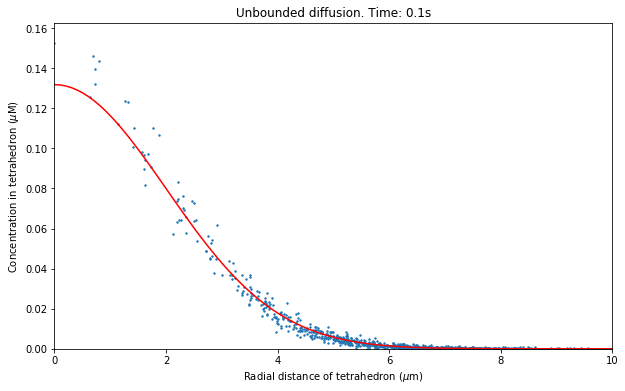

In [22]:
plt.figure(figsize=(10,6))
plotres(res_mean, 100)

### Simulation with TetOpSplit

Version 2.3 and later of STEPS include an approximate spatial stochastic solver called `TetOpSplit` ([steps.mpi.solver.TetOpSplit](API_mpisolver.rst#steps.mpi.solver.TetOpSplit)). This solver applies an approximation for diffusion whereas reactions are solved by the SSA. The solver is designed to approximate the exact solver, `Tetexact`, to high accuracy and may perform significantly faster then Tetexact for some models. A full description of the method is available at: [http://arxiv.org/abs/1512.03126](http://arxiv.org/abs/1512.03126). Although the method differs significantly from the exact stochastic solver, usage is very similar with only one different command necessary in this example to simulate the model with `TetOpSplit` instead of `Tetexact`. That is, instead of creating a Tetexact solver object we create a TetOpSplit solver object with the following command:


In [23]:
import steps.mpi.solver as mpisolvmod
 
sim_tos = mpisolvmod.TetOpSplit(model, tmgeom, rng, False, \
                                [0] * tmgeom.ntets)

-----------------------------------------------------------------
STEPS is running in parallel mode with  1  processes
-----------------------------------------------------------------


The model can be run with the exact same set of Python commands as for the previous simulation with `Tetexact`, using the reference to the `TetOpSplit` object `sim_tos,` writing over the data recorded to `NumPy` array res and recreating res_mean for use by the plotting function:

In [24]:
# Run NITER number of iterations:
for i in range(NITER):
    sim_tos.reset()
    # Inject all molecules into the central tet:
    sim_tos.setTetCount(ctetidx, 'A', NINJECT)
    for j in range(ntpnts):
        sim_tos.run(tpnts[j])
        # Loop over the tetrahedrons we are saving data for
        for k in range(SAMPLE):
            # Save the concentration in the tetrahedron, in uM
            res[i, j, k] = sim_tos.getTetConc(int(tetidxs[k]), 'A') * 1.0e6

res_mean = numpy.mean(res, axis=0)

We can now plot the results obtained with `TetOpSplit`

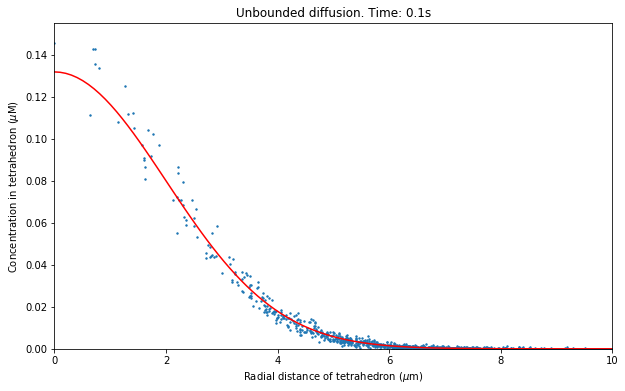

In [25]:
plt.figure(figsize=(10, 6))
plotres(res_mean, 100)